# Hand-in 3, Part 2: Data Modeling

In this part you will take the csv file "reduced_field_data.csv" from Part 1, and use it to estimate the line criticality indices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Score function

Below is a scoring function we have written for you. The output of this function is a score of how well your procedure is doing. Higher scores are worse!

As you can see, it penalizes heavily when you don't predict accurately values when they are being overloaded, i.e. false negatives.


In [2]:
def score_func(y_est, y_real):
    """
        This function takes your estimates y_est and
        scores them against the real data y_real.
        You should use this function to show how good your estimation method is.
    """
    # Square deviation
    sqr_err = np.sum(((y_est - y_real)**2).sum())
    # Penalty for not estimating a critical value above 0.95 when it occurs.
    false_negative = np.sum(np.where(np.logical_and(y_est < 0.95, y_real > 0.95), 10*np.sqrt(np.abs((y_est - y_real))), 0).sum())
    return sqr_err + false_negative

## Load and clean data

Load your data from the previous exercise as well as the criticality data.


In [3]:
# Data is loaded here
field_data = pd.read_csv("reduced_field_data.csv", index_col=0)
crit_data = pd.read_csv("flow_criticality_data.csv", index_col=0)



## Linear regression

We have implemented a simple linear regression to apply to your data.
You should use this as a benchmark for your neural network below.


In [4]:
# Slicing the data, because we have removed the NaN's of the field_data, which is therefore smaller than the crit_data
# Using the time column, from field_data
crit_data = crit_data[crit_data.index.isin(field_data['time'])].dropna(axis=0)
# We no longer need the time column, therefore we remove it
field_data = field_data.drop('time',1)

Overall error: 21633.9299


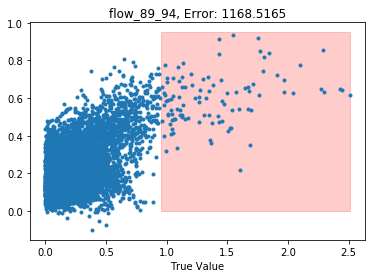

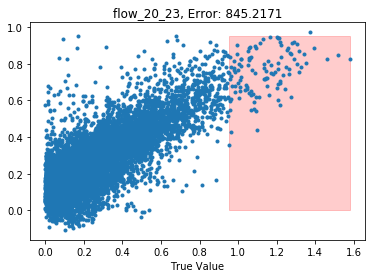

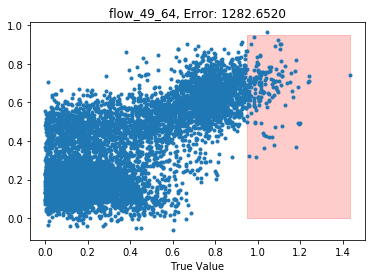

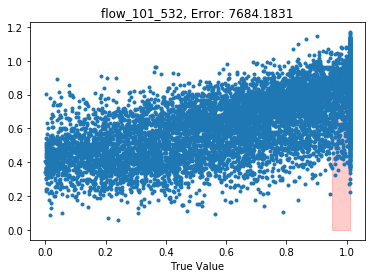

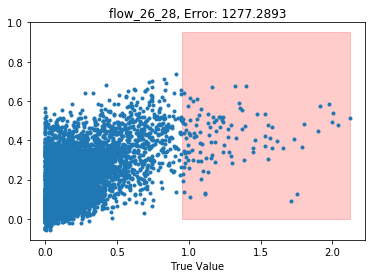

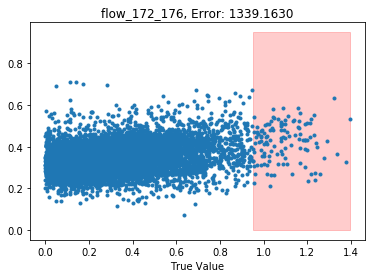

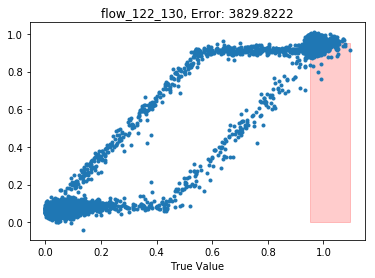

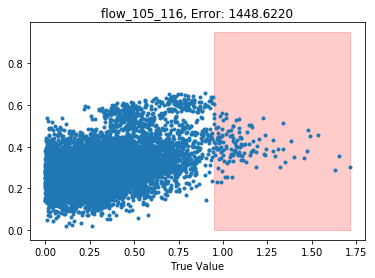

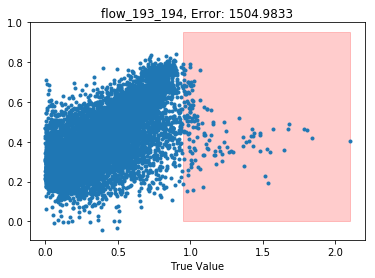

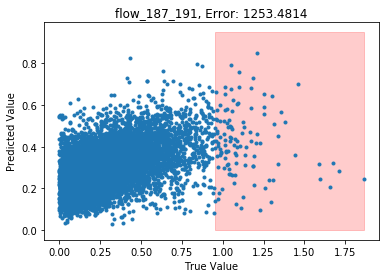

In [5]:
# The code below implements a linear regression on your data and compares predicted and true values.
# On the plots there is a red square indicating the areas corresponding to false negatives.
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(field_data,crit_data)

y_pred = lm.predict(field_data)
for index in range(10):
    plt.figure()
    plt.fill_between([0.95, crit_data.iloc[:,index].max()], [0.95, 0.95], color='r', alpha=0.2)
    plt.plot(crit_data.iloc[:,index],y_pred[:,index],'.')
    error = score_func(y_pred[:,index],crit_data.iloc[:,index])
    plt.title('{0}, Error: {1:.04f}'.format(crit_data.columns[index], error))
    plt.xlabel('True Value')

plt.ylabel('Predicted Value')
print('Overall error: {0:.04f}'.format(score_func(y_pred, crit_data)))


**Q#6** Would you recommend using Linear Regression for estimating line criticality indices? Why/why not?

*

# Neural Network

You should now produce a neural network that can estimate criticality indices.
Split your data into a training and test set, build your neural network below, and use the score_func defined above to estimate your model quality.

**Q#7** Explain why you chose the layers, nodes and activation functions you did. (No wrong answers, we want to know your thought process!) What is the best score you can get with a single layer?


For the NN Linear regression
We tried using the linear activation function. This gives a slow estimation, but gives a very good approximation. We ended up using the rectified linear activation function "relu", this gives a really quick and consistent estimation, but appears limited in the precission it can reach

We use the optimizer adam, as it is a memory light, computationally efficient algorithm
From reading, the standard parameters of tensorflow, should be pretty good. However we tweaked hte learning rate, to be slightly faster 0.001 -> 0.05. As this gave quick results, but still seem to narrow in on the same result quickly.

We made the neural network, with a single layer, using 10 nodes. We try to keepit simple with small amount of layers. and we get a pretty good approximation using just one layer

using linear, the best score was(however it was very inconsistent)
Epoch 50/50
6648/6648 [==============================] - 0s - loss: 0.1149     
Score:  5144.7368582568579

Using relu, the best score was
Epoch 3/3
6648/6648 [==============================] - 0s - loss: 0.2178     
Score:  16170.9507471

**Both results are better than the linear regression function**

In [6]:
# Split data into training and test

# Using the sklearn's builtin function, we split the data, so that 1/5 will be used for testing
# Given a random_state, to make the data reproducable
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(field_data, crit_data, test_size=0.20, random_state=42)

In [7]:
#INSERT Neural Network Code here for a linear regression.
random_state=100
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

model = Sequential()
model.add(Dense(10, input_shape=(20,)))
model.add(Activation('relu'))
adam = optimizers.Adam(lr=0.05, beta_1=0.95,
beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=adam)
model.fit(x_train.values,y_train.values,
epochs = 3, batch_size=250, shuffle=False)
y_pred = model.predict(x_test.values, batch_size = 1000)

print("Score: ", score_func(y_pred, y_test))


Using TensorFlow backend.


Epoch 1/3
7027/7027 [==============================] - 0s - loss: 23398.9747     
Epoch 2/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 3/3
7027/7027 [==============================] - 0s - loss: 0.2187     - ETA: 0s - loss: 0.218
Score:  16170.9507471


# K-fold cross validation

To ensure that your neural network actually works when presented with new data, take the neural network you defined above, and perform a k-fold cross validation on it.

**Q#8** Using a test window size of one tenth of your data (ten-fold cross validation), plot a histogram of the output of score_func for the validation. Tweak your neural network to achieve the lowest mean score.H

*We have done K-fold for both the relu and linear activation. it clearly shows that relu gives consistent results fast, however this is probably due to relu being undifferentiable in zero. Which leads to bad learning when values are zero*

*The linear activation can get better scores, however needs more epochs to reach them, and is not very consistent in the k-fold. However this can probably be fixed by more finetuning optimizer.*

In [15]:
# Your k-fold code goes here.

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()
kf1 = KFold(n_splits=10,shuffle=True)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data.iloc[train_index], crit_data.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(20,)))
    model.add(Activation('relu'))
    
    adam = optimizers.Adam(lr=0.05, beta_1=0.95,
                            beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1 = model.fit(x_train.values,y_train.values, epochs=3, batch_size=250, shuffle=True)
    y_pred2 = model.predict(x_test.values, batch_size=1000)
    listOfErrors2.append(score_func(y_pred2, y_test))

Epoch 1/3
7027/7027 [==============================] - 0s - loss: 22020.9685     
Epoch 2/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 3/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 1/3
7027/7027 [==============================] - 0s - loss: 5358.6285     
Epoch 2/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 3/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 1/3
7027/7027 [==============================] - 0s - loss: 12925.9511     
Epoch 2/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 3/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 1/3
7027/7027 [==============================] - 0s - loss: 7563.5458     
Epoch 2/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 3/3
7027/7027 [==============================] - 0s - loss: 0.2187     
Epoch 1/3
7027/7027 [=============================

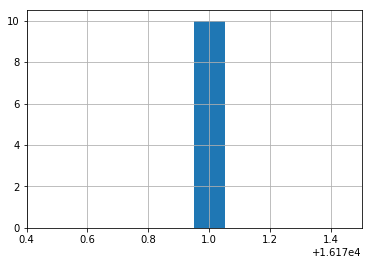

Mean score:  16170.9507471
KFold scores:  [16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065, 16170.950747078065]


In [9]:


plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("Mean score: " , np.mean(listOfErrors2))
print("KFold scores: ", listOfErrors2)



In [16]:
# k-fold of the linear version

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers

listOfErrors2 = list()
kf1 = KFold(n_splits=10,shuffle=True)
for train_index, test_index in kf1.split(field_data):
    X_train, X_test = field_data.iloc[train_index], field_data.iloc[test_index]
    Y_train, Y_test = crit_data.iloc[train_index], crit_data.iloc[test_index]
    #print(X_test)
    model = Sequential()
    model.add(Dense(10, input_shape=(20,)))
    model.add(Activation('linear'))
    model.add(Dense(10,))
    model.add(Activation('linear'))
    
    adam = optimizers.Adam(lr=0.0095, beta_1=0.97,
                            beta_2=0.999, epsilon=1e-085, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=adam)
    history1 = model.fit(x_train.values,y_train.values, epochs=50, batch_size=100, shuffle=True)
    y_pred2 = model.predict(x_test.values, batch_size=1000)
    listOfErrors2.append(score_func(y_pred2, y_test))

Epoch 1/50
7027/7027 [==============================] - 0s - loss: 23301.9689     
Epoch 2/50
7027/7027 [==============================] - 0s - loss: 1416.9929     
Epoch 3/50
7027/7027 [==============================] - 0s - loss: 211.4316     
Epoch 4/50
7027/7027 [==============================] - 0s - loss: 70.8040     
Epoch 5/50
7027/7027 [==============================] - 0s - loss: 36.6797     
Epoch 6/50
7027/7027 [==============================] - 0s - loss: 23.4138     
Epoch 7/50
7027/7027 [==============================] - 0s - loss: 16.1950     
Epoch 8/50
7027/7027 [==============================] - 0s - loss: 11.4954     
Epoch 9/50
7027/7027 [==============================] - 0s - loss: 8.5146     
Epoch 10/50
7027/7027 [==============================] - 0s - loss: 6.5621     
Epoch 11/50
7027/7027 [==============================] - 0s - loss: 5.1644     
Epoch 12/50
7027/7027 [==============================] - 0s - loss: 4.1583     
Epoch 13/50
7027/7027 [============

7027/7027 [==============================] - 0s - loss: 2000.2281     
Epoch 3/50
7027/7027 [==============================] - 0s - loss: 413.9140     
Epoch 4/50
7027/7027 [==============================] - 0s - loss: 130.4154     
Epoch 5/50
7027/7027 [==============================] - 0s - loss: 62.9406     
Epoch 6/50
7027/7027 [==============================] - 0s - loss: 37.7027     
Epoch 7/50
7027/7027 [==============================] - 0s - loss: 25.4376     
Epoch 8/50
7027/7027 [==============================] - 0s - loss: 18.4615     
Epoch 9/50
7027/7027 [==============================] - 0s - loss: 14.1314     
Epoch 10/50
7027/7027 [==============================] - 0s - loss: 11.2338     
Epoch 11/50
7027/7027 [==============================] - 0s - loss: 9.1705     
Epoch 12/50
7027/7027 [==============================] - 0s - loss: 7.6498     
Epoch 13/50
7027/7027 [==============================] - 0s - loss: 6.4625     
Epoch 14/50
7027/7027 [=======================

7027/7027 [==============================] - 0s - loss: 495.4507     
Epoch 4/50
7027/7027 [==============================] - 0s - loss: 148.7993     
Epoch 5/50
7027/7027 [==============================] - 0s - loss: 73.7162     
Epoch 6/50
7027/7027 [==============================] - 0s - loss: 50.4460     
Epoch 7/50
7027/7027 [==============================] - 0s - loss: 38.3683     
Epoch 8/50
7027/7027 [==============================] - 0s - loss: 30.6419     
Epoch 9/50
7027/7027 [==============================] - 0s - loss: 24.9924     
Epoch 10/50
7027/7027 [==============================] - 0s - loss: 20.7889     
Epoch 11/50
7027/7027 [==============================] - 0s - loss: 17.4488     
Epoch 12/50
7027/7027 [==============================] - 0s - loss: 14.7092     
Epoch 13/50
7027/7027 [==============================] - 0s - loss: 12.5318     
Epoch 14/50
7027/7027 [==============================] - 0s - loss: 10.6801     
Epoch 15/50
7027/7027 [=====================

7027/7027 [==============================] - 0s - loss: 46.5589     
Epoch 5/50
7027/7027 [==============================] - 0s - loss: 19.7996     
Epoch 6/50
7027/7027 [==============================] - 0s - loss: 12.0483     
Epoch 7/50
7027/7027 [==============================] - 0s - loss: 8.3224     
Epoch 8/50
7027/7027 [==============================] - 0s - loss: 6.0894     
Epoch 9/50
7027/7027 [==============================] - 0s - loss: 4.5536     
Epoch 10/50
7027/7027 [==============================] - 0s - loss: 3.4961     
Epoch 11/50
7027/7027 [==============================] - 0s - loss: 2.7252     
Epoch 12/50
7027/7027 [==============================] - 0s - loss: 2.1278     
Epoch 13/50
7027/7027 [==============================] - 0s - loss: 1.7141     
Epoch 14/50
7027/7027 [==============================] - 0s - loss: 1.3815     
Epoch 15/50
7027/7027 [==============================] - 0s - loss: 1.1305     
Epoch 16/50
7027/7027 [==============================]

7027/7027 [==============================] - 0s - loss: 117.4287     
Epoch 6/50
7027/7027 [==============================] - 0s - loss: 75.7336     
Epoch 7/50
7027/7027 [==============================] - 0s - loss: 52.6219     
Epoch 8/50
7027/7027 [==============================] - 0s - loss: 38.0591     
Epoch 9/50
7027/7027 [==============================] - 0s - loss: 28.0541     
Epoch 10/50
7027/7027 [==============================] - 0s - loss: 21.2165     
Epoch 11/50
7027/7027 [==============================] - 0s - loss: 16.3932     
Epoch 12/50
7027/7027 [==============================] - 0s - loss: 12.9092     
Epoch 13/50
7027/7027 [==============================] - 0s - loss: 10.3395     
Epoch 14/50
7027/7027 [==============================] - 0s - loss: 8.4590     
Epoch 15/50
7027/7027 [==============================] - 0s - loss: 7.0641     
Epoch 16/50
7027/7027 [==============================] - 0s - loss: 6.0288     
Epoch 17/50
7027/7027 [=======================

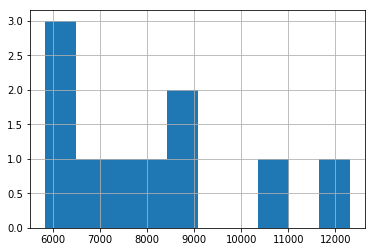

Mean score:  8080.57198528
KFold scores:  [7330.8807453644667, 8090.9648917266559, 8533.2460090940622, 6309.6530899060817, 8675.4552867226685, 6019.2536692238464, 5846.2963026710186, 12306.420909622357, 10967.475597697452, 6726.0733507231371]


In [17]:
plt.hist(listOfErrors2)
plt.grid(True)
plt.show()

print("Mean score: " , np.mean(listOfErrors2))
print("KFold scores: ", listOfErrors2)


**Q#9** Are you satisfied with the quality of the final estimator? What would be your recommendation for your boss on this issue?

*Using the relu activation function, gives fast and consisten estimations, though they are limited in their precision.*

*However the linear activation function gives great precision, but requires many iterations, and therefore a lot more time, and is not very consistent. Possible you can tune the values, and get some consistent high-precision results.*

*The problem using relu, is that it is not differentiable in zero, and this data has a lot of zero's therefore it will not learn well.*

*I would definately recomend using the linear neural network over both the relu and the linear regression algorithm. as it gives good precision, and it a better estimate, even when it doesn't give the best results*

# Extra task for 3-person groups

**Q#10** Repeat the process, once reducing to 15 sensors, and once reducing to 25 sensors. The costs to keep these sensors running is directly proportional to the number of sensors used. Does changing the number of sensors used change your conclusion in Q#9?

**We are only 2 people**